className = sky1_Strategy

author = sky

交易思路：

交易逻辑：

30min：

1.计算MA20.,A40,MQ60,MA90的聚合程度 小于0.79 param：Trend

2.计算涨跌幅度 大于0.35 param：wave

3.MA20 往上 and 股价在MA20上面（空头相反） param：corssover,crossbelow


开仓条件： 同时满足上面3个条件

多头出场条件： 80%止盈或者股价跌破20日均线

空头出场条件：40%最高价浮动止损或者80%止盈

适用品种：ETH

In [8]:
# coding: utf-8
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)

from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime


class sky1_Strategy(CtaTemplate):
    className = 'sky1_Strategy'
    author = 'ChannelCMT'

    # 策略交易标的
    symbol = EMPTY_STRING  
    posDict = {}  # 仓位数据缓存
    eveningDict = {}  # 可平仓量数据缓存
    bondDict = {}  # 保证金数据缓存

    # 策略参数
    Window1 = 20     
    Window2 = 40     
    Window3 = 60
    Window4 = 90
    initDays = 2       # 初始化数据所用的天数
    trailingPercent = 4
    fixsize = 1
    prop = 0.79
    prop1 = 0.35
    stopRatio = 0.02       # 止损百分比
    profitMultiplier = 8   # 止盈与止损比例

    # 策略变量
    initbars = 100  # 获取历史数据的条数
    fastMa0 = EMPTY_FLOAT  
    fastMa1 = EMPTY_FLOAT   
    Ma1 = EMPTY_FLOAT 
    Ma2 = EMPTY_FLOAT   
    Ma3 = EMPTY_FLOAT
    Ma4 = EMPTY_FLOAT
    trend = 0             # 均线趋势，多头1，空头-1
    wave = 0
    Ma_exit = EMPTY_FLOAT 

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'Window1',
                 'Window2',
                'Window3',
                'Window4',
                'trailingPercent',
                'fixsize',
                'prop',
                'prop1',
                'stopRatio',
                'profitMultiplier']     

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'posSize',
               'fastMa0',
               'fastMa1',
               'Ma1',
               'Ma2',
               'Ma3',
               'Ma4',
               'trend',
              'wave']  

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""

        super(sky1_Strategy, self).__init__(ctaEngine, setting)
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}
        # ----------------------------------------------------------------------

    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：初始化' % self.className)
        self.symbol = self.symbolList[0]

        # 构造K线合成器对象
        self.bgDict = {
            sym: BarGenerator(self.onBar)
            for sym in self.symbolList
        }
        
        self.amDict = {
            sym: ArrayManager()
            for sym in self.symbolList
        }

        self.bg30 = BarGenerator(self.onBar, 30, self.on30MinBar)
        self.bg30Dict = {
            sym: self.bg30
            for sym in self.symbolList
        }

#         self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
#         self.bg15Dict = {
#             sym: self.bg15

#             for sym in self.symbolList
#         }

        # 生成Bar数组
        self.am30Dict = {
            sym: ArrayManager(size=self.Window4+10)
            for sym in self.symbolList
        }

#         self.am15Dict = {
#             sym: ArrayManager(size=self.slowWindow + 10)
#             for sym in self.symbolList
#         }


        self.putEvent()
        '''
        在点击初始化策略时触发,载入历史数据,会推送到onbar去执行updatebar,但此时ctaEngine下单逻辑为False,不会触发下单.
        '''
#         pastbar15 = self.loadHistoryBar(self.symbol,'15min',1000)[:-80]
#         pastbar60 = self.loadHistoryBar(self.symbol,'60min',1000)[:-20]
#         pastbar1 = self.loadHistoryBar(self.symbol,'1min',1200)

#         for bar15 in pastbar15:
#             self.am15Dict[self.symbol].updateBar(bar15)

#         for bar60 in pastbar60:
#             self.am60Dict[self.symbol].updateBar(bar60)

#         for bar1 in pastbar1:
#             self.onBar(bar1)

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：启动' % self.className)
        # self.ctaEngine.loadSyncData(self)    # 加载当前正确的持仓
        self.putEvent()
        '''
        在点击启动策略时触发,此时的ctaEngine会将下单逻辑改为True,此时开始推送到onbar的数据会触发下单.
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：停止' % self.className)
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """从错误状态恢复策略（必须由用户集成实现）"""
#         self.writeCtaLog(u'策略%s：恢复策略状态成功' % self.Name)
        self.putEvent()
    
    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        self.bgDict[tick.vtSymbol].updateTick(tick)
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到1分钟K线推送"""
        self.cancelAll()
        # 基于60分钟判断趋势过滤，因此先更新

        bg30 = self.bg30Dict[self.symbol]
        bg30.updateBar(bar)

        # 基于15分钟判断
#         bg15 = self.bg15Dict[self.symbol]
#         bg15.updateBar(bar)
        if self.posDict[self.symbol+"_LONG"] == 0 and self.posDict[self.symbol+"_SHORT"] == 0:
            self.intraTradeHighDict[self.symbol] = 0
            self.intraTradeLowDict[self.symbol] = 999999
        # 洗价器
        elif (self.posDict[self.symbol+"_LONG"] > 0):
            self.intraTradeHighDict[self.symbol] = max(self.intraTradeHighDict[self.symbol], bar.high)
            self.intraTradeLowDict[self.symbol] = bar.low
            self.longStop = self.intraTradeHighDict[self.symbol]*(1-self.trailingPercent/100)
#             print('最高价:%s'%self.intraTradeHighDict[symbol])
#             print('止损价格:%s'%self.longStop)
#             print('开仓价格:%s'%self.transactionPrice)
            if (bar.close<=self.Ma_exit) or (bar.close > self.transactionPrice * (1 + self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.sell(self.symbol, bar.close*0.9, self.fixsize,marketPrice="0",levelRate = 10)
#                 self.writeCtaLog('平多仓 止盈或止损')
        elif (self.posDict[self.symbol+"_SHORT"] > 0):
            self.intraTradeLowDict[self.symbol] = min(self.intraTradeLowDict[self.symbol], bar.low)
            self.intraTradeHighDict[self.symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[self.symbol]*(1+self.trailingPercent/100)
            if (bar.close>=self.shortStop) or (bar.close < self.transactionPrice * (1 - self.profitMultiplier * self.stopRatio)):
                self.cancelAll()
                self.cover(self.symbol, bar.close*1.1, self.fixsize,marketPrice="0",levelRate = 10)
#                 self.writeCtaLog('平空仓 止盈或止损')
        
        # 移动止损和固定止盈洗价器-2018年9月1日 17:12:22
        # if (self.posDict[self.symbol+"_LONG"] > 0):
        #     # 多头移动止损和固定止盈
        #     self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
        #     self.intraTradeLow = bar.low
        #     self.longStop = self.intraTradeHigh*(1-self.stopRatio)
        #     self.lone_exit = self.transactionPrice * (1 + 2 * self.stopRatio)
        #     self.writeCtaLog('多头止损价格:%s'%self.longStop)
        #     self.writeCtaLog('多头止盈价格:%s'%self.lone_exit)           
        #     if bar.close<=self.longStop:
        #         self.cancelAll()
        #         self.sell(self.symbol, bar.close*0.98, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' %self.transactionPrice)

        # elif self.posDict[self.symbol+"_SHORT"] >0:
        #     self.intraTradeLow = min(self.intraTradeLow, bar.low)
        #     self.intraTradeHigh = bar.high
        #     self.shortStop = self.intraTradeLow*(1+self.stopRatio)
        #     self.shortexit = self.transactionPrice * (1 - 2* self.stopRatio)
        #     self.writeCtaLog('空头止损价格:%s' % self.shortStop)
        #     self.writeCtaLog('空头止盈价格:%s' % self.shortexit)
        #     if bar.close>=self.shortStop:
        #         self.cancelAll()
        #         self.cover(self.symbol, bar.close*1.02, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' % self.transactionPrice)
            
        self.putEvent()

        # ----------------------------------------------------------------------
    def on30MinBar(self, bar):
            """60分钟K线推送"""

            am30 = self.am30Dict[self.symbol]
            am30.updateBar(bar)

            if not am30.inited:
                return

            Ma1 = ta.MA(am30.close, self.Window1)
        
            self.fastMa0 = Ma1[-1]

            self.fastMa1 = Ma1[-2]

            Ma2 = ta.MA(am30.close, self.Window2)

            Ma3 = ta.MA(am30.close, self.Window3)

            Ma4 = ta.MA(am30.close, self.Window4)
            self.Ma_exit = Ma4[-1]

            maxma = max(Ma1[-1],Ma2[-1],Ma3[-1],Ma4[-1])
            minma = min(Ma1[-1],Ma2[-1],Ma3[-1],Ma4[-1])

            agg = (maxma-minma)/minma*100
            if agg<self.prop:
                self.trend = 1
            else:
                self.trend = 0

            change = (am30.close[-1]-am30.close[-2])/am30.close[-2]*100
            if change>self.prop1:
                self.wave = 1
            elif change<=self.prop1:
                self.wave = -1
            else:
                self.wave = 0




            # 判断买卖
            crossOver = (self.fastMa0>self.fastMa1 and am30.close[-1]>self.fastMa0)      # 均线上涨
            crossBelow = (self.fastMa0<self.fastMa1 and am30.close[-1]<self.fastMa0)    # 均线下跌


            # 金叉和死叉的条件是互斥
            if (crossOver and self.trend==1 and self.wave==1):
                # 如果金叉时手头没有持仓，则直接做多
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0):
                    self.buy(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)
                # 如果有空头持仓，则先平空，再做多
                elif self.posDict[self.symbol+"_SHORT"] == 1:
                    self.cover(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)
                    self.buy(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)

            # 死叉和金叉相反
            elif (crossBelow and self.trend==1 and self.wave==-1) :
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0):
                    self.short(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)
                elif self.posDict[self.symbol+"_LONG"] == 1:
                    self.sell(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)
                    self.short(self.symbol,bar.close, self.fixsize,marketPrice="0",levelRate = 10)
            
            # 发出状态更新事件
            self.putEvent()

            # ----------------------------------------------------------------------



    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""

        self.putEvent()

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交信息变化推送"""
        #print("\n\n\n\n stg onTrade", trade.vtSymbol)
        self.transactionPrice = trade.price
#         print('trade direction',trade.direction,'offset',trade.offset,'price',trade.price, trade.dt)

#         self.writeCtaLog('onTrade price:%s'%trade.price)
        # self.saveSyncData()
        pass

    # ---------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [9]:
def runbacktest1(symboll):
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180301 01:01',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180905 01:01')
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(100000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':[symboll]}          # 策略参数配置
    engine.initStrategy(sky1_Strategy, d)    # 创建策略对象
    engine.runBacktesting()
    # 显示逐日回测结果
    engine.showDailyResult()
    # 显示逐笔回测结果
    engine.showBacktestingResult()

仓位字典构造完成 
初始仓位: {'ETHUSDT:binance_LONG': 0, 'ETHUSDT:binance_SHORT': 0} 
可平仓量: {'ETHUSDT:binance_LONG': 0, 'ETHUSDT:binance_SHORT': 0}
2018-09-11 19:43:16.865349	开始回测
2018-09-11 19:43:16.866343	策略初始化
2018-09-11 19:43:16.866343	载入历史数据。数据范围:[20180228 01:01,20180301 01:01)
2018-09-11 19:43:17.220353	载入完成，数据量：1381
2018-09-11 19:43:17.221375	策略初始化完成
2018-09-11 19:43:17.221375	策略启动完成
2018-09-11 19:43:17.221375	开始回放回测数据,回测范围:[20180301 01:01,20180905 01:01)
2018-09-11 19:43:17.264524	载入历史数据。数据范围:[20180301 01:01,20180905 01:01)
2018-09-11 19:44:30.342894	no Mongo connection, attempt using local data
2018-09-11 19:44:30.457821	载入完成，数据量：269499
2018-09-11 19:44:30.484804	当前回放数据:[20180301 01:01,20180905 01:01)
2018-09-11 19:44:35.144921	数据回放结束ss: 100%    
2018-09-11 19:44:35.144921	计算按日统计结果
2018-09-11 19:44:35.190890	------------------------------
2018-09-11 19:44:35.190890	首个交易日：	2018-03-01 00:00:00
2018-09-11 19:44:35.190890	最后交易日：	2018-09-05 00:00:00
2018-09-11 19:44:35.191889	总交易日：	189
2018-09-

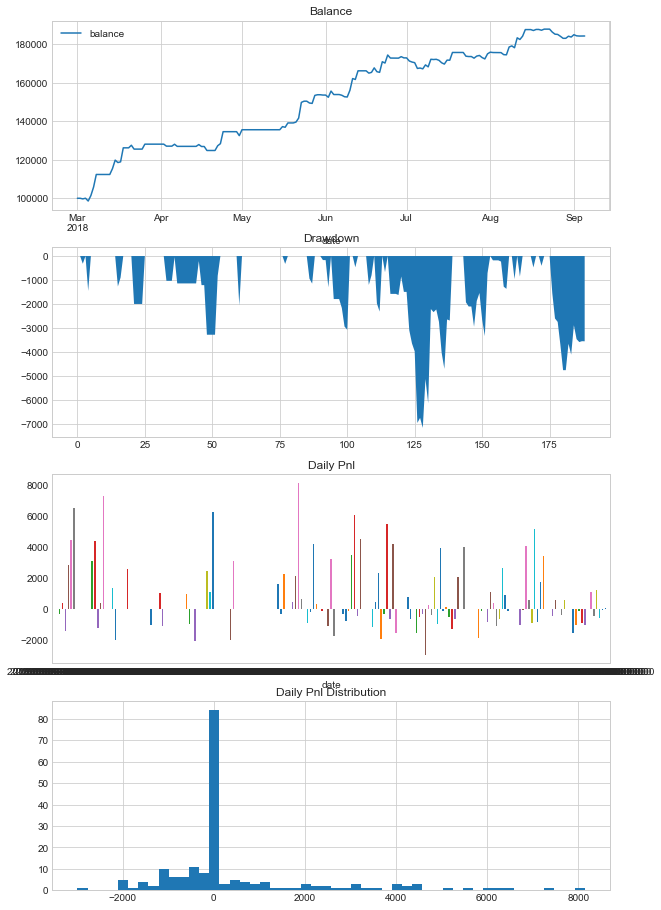

2018-09-11 19:44:37.923246	计算回测结果
单笔盈亏： -0.9240441767536165 开仓： 2018-03-03 16:31:00 ,  858.37 平仓: 2018-03-05 02:31:00 ,  865.1 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.8139105305745048 开仓： 2018-03-05 02:31:00 ,  865.1 平仓: 2018-03-05 23:28:00 ,  859.27 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 16.00739783443939 开仓： 2018-03-06 01:01:00 ,  858.9 平仓: 2018-03-08 01:22:00 ,  720.21 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 10.843991711296276 开仓： 2018-03-14 17:31:00 ,  685.27 平仓: 2018-03-15 06:20:00 ,  610.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.194611223686636 开仓： 2018-03-16 19:01:00 ,  597.13 平仓: 2018-03-16 21:31:00 ,  615.37 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.104671660951953 开仓： 2018-03-16 21:31:00 ,  615.37 平仓: 2018-03-17 07:40:00 ,  603.28 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 15.8938540795504 开仓： 2018-03-17 11:31:00 ,  597.86 平仓: 2018-03-18 18:33:00 ,  502.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.2219000089118506 开仓： 2018-03-21 04:01:00 ,  561.05 平仓: 

单笔盈亏： 8.871102504518461 开仓： 2018-07-30 12:01:00 ,  464.76 平仓: 2018-08-02 08:12:00 ,  422.88 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.8145998470910212 开仓： 2018-08-05 01:01:00 ,  405.47 平仓: 2018-08-06 05:01:00 ,  412.26 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -1.1175384466113554 开仓： 2018-08-06 05:01:00 ,  412.26 平仓: 2018-08-06 07:35:00 ,  408.23 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.5199225542485576 开仓： 2018-08-06 08:31:00 ,  410.61 平仓: 2018-08-06 16:01:00 ,  409.05 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 0.5078425620339895 开仓： 2018-08-06 16:01:00 ,  409.05 平仓: 2018-08-07 07:31:00 ,  406.4 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.07602362204723234 开仓： 2018-08-07 07:31:00 ,  406.4 平仓: 2018-08-07 07:32:00 ,  406.66 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.3086052194311401 开仓： 2018-08-07 15:31:00 ,  409.24 平仓: 2018-08-08 01:31:00 ,  408.55 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 11.47669318320892 开仓： 2018-08-08 01:31:00 ,  408.55 平仓: 2018-08-09 03:07:00 ,  361.09

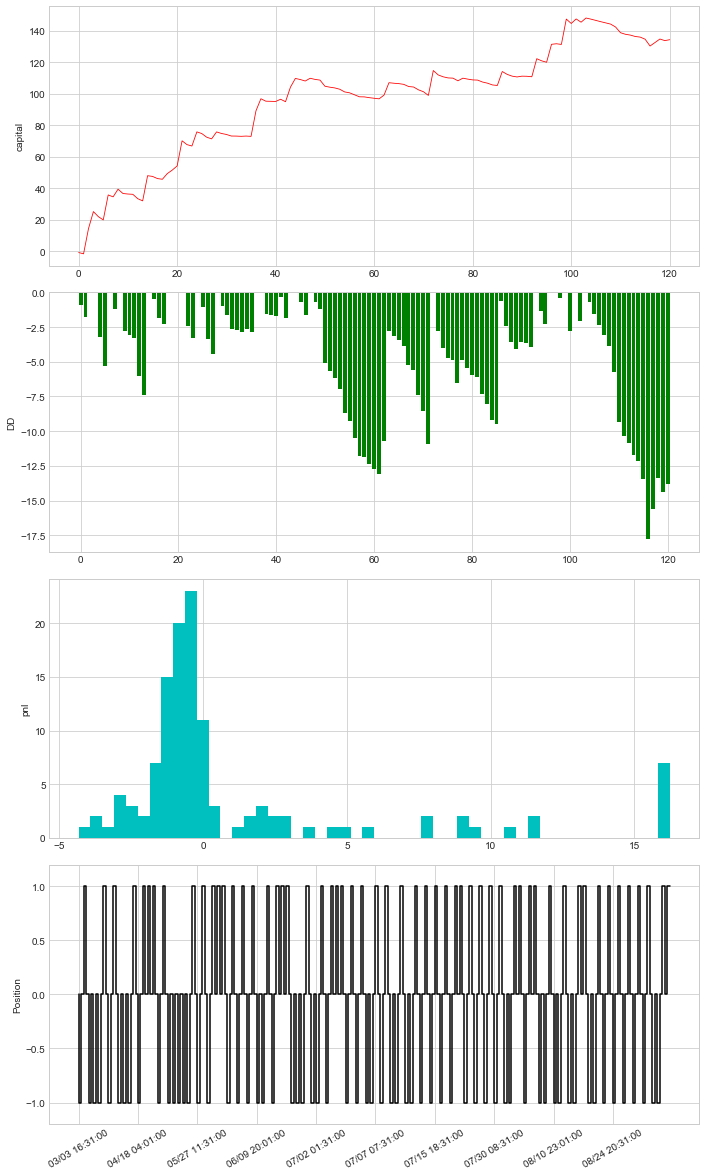

In [10]:
runbacktest1('ETHUSDT:binance')